# Salary Prediction from LinkedIn Job Postings - Train Gradient Boosting Model

In [ ]:
import xgboost as xgb
import pandas as pd, numpy as np
import salary
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, TargetEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
import joblib

In [7]:
sns.set_theme()

## Train & Evaluate Models

In [8]:
(X_train, y_train) = salary.get_train_dataset()
(X_test, y_test) = salary.get_test_dataset()

In [9]:
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('one_hot_encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['norm_title', 'clustered_edu_req', 'clustered_pref_qual', 'clustered_req_skill', 'location_state', 'company_industries', 'formatted_experience_level', 'formatted_work_type']),
            ('target_encoder', TargetEncoder(random_state=42), ['norm_title', 'clustered_edu_req', 'clustered_pref_qual', 'clustered_req_skill', 'location_state', 'company_industries', 'formatted_experience_level', 'formatted_work_type']),
            ('experience_level', salary.experience_level_encoder, ['formatted_experience_level']),
            ('work_type', salary.work_type_encoder, ['formatted_work_type']),
            ('remote_allowed', 'passthrough', ['remote_allowed']),
            ('company_employee_count', SimpleImputer(strategy='median'), ['company_employee_count']),
        ],
        remainder='drop'
    ),
    StandardScaler(),
)

### XGBoost

In [30]:
model_xgb = make_pipeline(
    clone(preprocessor),
    BayesSearchCV(
        estimator=xgb.XGBRegressor(n_estimators=500, objective='reg:tweedie', random_state=42),
        search_spaces={
            'max_depth': (7,),
            'min_child_weight': (5,),  
            'eta': (0.1,), 
            'subsample': (0.9,),
            'colsample_bytree': (0.5,), 
            'gamma': (0,),  
            'reg_alpha': (0.1,), 
            'reg_lambda': (0.1,)  
        },
        scoring='r2',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_iter=1, 
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [32]:
model_xgb

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['norm_title',
                                                                    'clustered_edu_req',
                                                                    'clustered_pref_qual',
                                                                    'clustered_req_skill',
                                                                    'location_state',
                                                                    'company_industries',
                                                                    'formatted_experience_level',
                                                                    'formatted_work_type']),
                                                                  ('targ...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=500,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...),
                               n_iter=1, n_jobs=-1, random_state=42,
                               scoring='r2',
                               search_spaces={'colsample_bytree': (0.5,),
                                              'eta': (0.1,), 'gamma': (0,),
                                              'max_depth': (7,),
                                              'min_child_weight': (5,),
                                              'reg_alpha': (0.1,),
                                              'reg_lambda': (0.1,),
                                              'subsample': (0.9,)},
                               verbose=1))])

In [33]:
result_xgb_train = salary.evaluate_train_predictions(model_xgb.predict(X_train))
result_xgb_test = salary.evaluate_test_predictions(model_xgb.predict(X_test))

Train R2: 0.7437
Train RMSE: 31139.7306
Train MAE: 19408.6477
Test R2: 0.5643
Test RMSE: 38483.4519
Test MAE: 24576.3592


## Check Feature Importance

,Feature,Importance
0,one_hot_encoder__formatted_experience_level_Executive,0.03687
1,experience_level__formatted_experience_level,0.035809
2,one_hot_encoder__formatted_experience_level_Director,0.031887
3,one_hot_encoder__company_industries_Legal Services,0.026845
4,target_encoder__norm_title,0.025441
5,one_hot_encoder__company_industries_Retail,0.023035
6,one_hot_encoder__formatted_experience_level_Entry level,0.016901
7,target_encoder__formatted_experience_level,0.015145
8,target_encoder__company_industries,0.014772
9,one_hot_encoder__clustered_edu_req_High school diploma or equivalent,0.013934


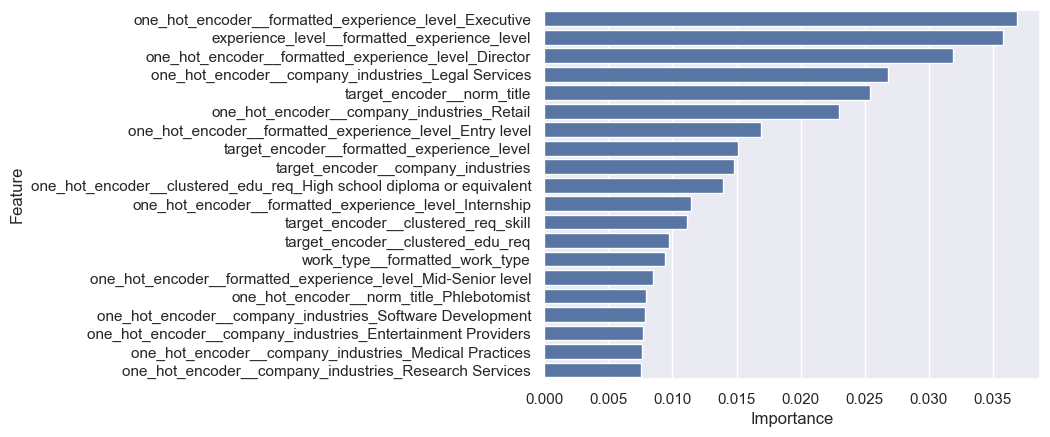

In [34]:
'''
Show top 20 important features
'''
def get_important_features(preocessor, model, n=20):
    feature_names = preocessor.get_feature_names_out(X_train.columns)
    importances = model.feature_importances_
    idxs = np.flip(np.argsort(np.abs(importances)))
    importance_df = pd.DataFrame([feature_names[idxs], importances[idxs]], index=["Feature", "Importance"]).transpose()
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(n))
    pd.set_option('display.max_colwidth', None)
    return importance_df[:n]


get_important_features(model_xgb[0], model_xgb[-1].best_estimator_)

## Do Error Analysis

In [35]:
y_test_preds = model_xgb.predict(X_test)
resids = (y_test - y_test_preds).rename('residual')
abs_error = np.abs(resids).rename('abs_error')
X_test_results = pd.concat([X_test, y_test, pd.Series(y_test_preds, index=y_test.index, name='predicted_salary'), resids, abs_error], axis=1)
X_test_results

job_id                                           title  \
10953  3898168698  Staffing Industry Branch Manager - NYC office    
29454  3905289191                          Manufacturing Engineer   
21866  3903470856                   Physician Assistant Full Time   
5673   3889403735                                 Payroll Manager   
22924  3903832397         Data Analyst - Python/AWS (W2) (REMOTE)   
...           ...                                             ...   
13484  3901175485                             Family Law Attorney   
23772  3903895678                              Quality Technician   
27595  3904954999                      Sales & Leasing Specialist   
3410   3887570772  Heavy Civil Construction - Estimator (Asphalt)   
18220  3902347695                      Customer Care Professional   

                              location location_state  \
10953                     New York, NY             NY   
29454                         Cary, IL             IL   
21866                    Patchogue, NY             NY   
5673   New York City Metropolitan Area        Unknown   
22924                    United States        Unknown   
...                                ...            ...   
13484                    San Diego, CA             CA   
23772                       Tucson, AZ             AZ   
27595                      Mankato, MN             MN   
3410                      Marietta, GA             GA   
18220                      El Paso, TX             TX   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

<Axes: xlabel='residual', ylabel='Count'>

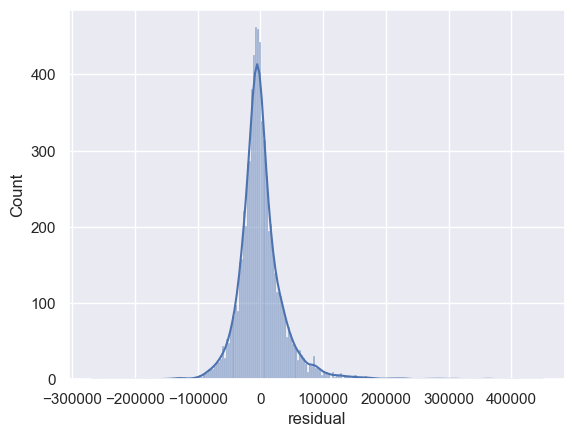

In [36]:
# Residuals look pretty normally distributed
sns.histplot(X_test_results['residual'], kde=True)

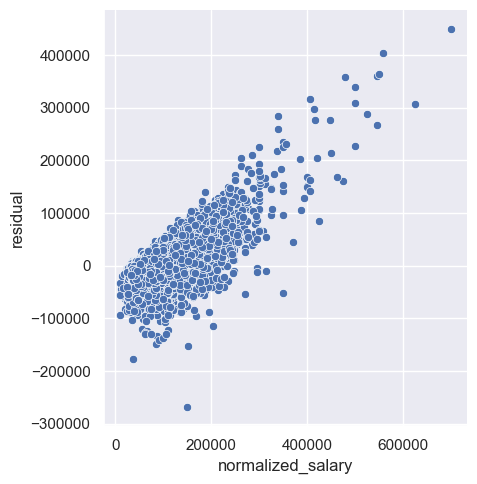

In [38]:
'''
In general, the higher the residual, the more the model underestimates the salary.
It sometimes overestimates the salary for lower salaries.
'''
sns.relplot(x='normalized_salary', y='residual', data=X_test_results, kind='scatter')

In [39]:
'''
Tends to underestimate (top 5): Nurse Practitioner, Phlebotomist, Associate Attorney, Electrical Engineer
Tends to overestimate (top 5): General Manager, Business Development Manager, Sales Representative, Accountant, Controller
'''
X_test_results.groupby('norm_title').agg({'residual': 'mean', 'norm_title': 'count'}).sort_values(by='residual')

,residual,norm_title
norm_title,,
Executive Assistant,-5457.147348,68
Sales Representative,-5402.818992,42
Data Engineer,-4401.592272,92
Accountant,-4130.469256,54
General Manager,-3802.793950,43
...,...,...
Mortgage Loan Officer,6702.307062,51
Team Member,7358.539234,25
Quality Engineer,7630.937054,156


In [40]:
'''
Norm titles with the worst absolute errors
'''
X_test_results.groupby('norm_title').agg({'abs_error': 'mean', 'norm_title': 'count'}).sort_values(by='abs_error').tail(10)

,abs_error,norm_title
norm_title,,
Business Development Manager,32966.695059,74
General Manager,33004.420403,43
Outside Sales Representative,33227.367391,69
Senior Project Manager,34666.055642,110
Mortgage Loan Officer,36716.523146,51
Sales Executive,37201.917596,128
Nurse Practitioner,39674.962753,74
Medical Assistant,40206.280783,176
Associate Attorney,40283.988124,127


In [41]:
X_test_results.groupby('formatted_experience_level').agg({'abs_error': 'mean', 'formatted_experience_level': 'count'}).sort_values(by='abs_error')

,abs_error,formatted_experience_level
formatted_experience_level,,
Internship,15471.790120,59
Entry level,16015.242464,1765
Associate,20278.149149,777
Unknown,27429.794941,1582
Mid-Senior level,27867.351587,2466
Director,37437.471486,250
Executive,67620.873149,73


In [42]:
X_test_results.groupby('formatted_work_type').agg({'abs_error': 'mean', 'formatted_work_type': 'count'}).sort_values(by='abs_error')

,abs_error,formatted_work_type
formatted_work_type,,
Volunteer,829.730469,2
Part-time,13850.067084,452
Internship,16059.335616,45
Temporary,16799.347939,69
Full-time,25296.380312,5632
Contract,26353.607752,748
Other,42539.552702,24


In [43]:
X_test_results.sort_values(by='abs_error')[['job_id', 'title', 'norm_title', 'location', 'formatted_work_type', 'formatted_experience_level', 'normalized_salary', 'predicted_salary', 'residual']].tail(10)

,job_id,title,norm_title,location,formatted_work_type,formatted_experience_level,normalized_salary,predicted_salary,residual
14469,3901377257,Psychiatrist,Physical Therapist,"New York, United States",Contract,Unknown,415000.0,117213.796875,297786.203125
27032,3904921870,Oral Surgeon,Phlebotomist,"Murfreesboro, TN",Full-time,Mid-Senior level,625000.0,318164.656250,306835.343750
29214,3905259087,"Chief Product Officer, Slack",Senior Software Engineer,"San Francisco, CA",Full-time,Mid-Senior level,499000.0,190500.781250,308499.218750
27690,3904959000,Psychiatrist,Physical Therapist,"Grafton, OH",Part-time,Unknown,405600.0,89175.632812,316424.367188
19587,3902780751,Director of Construction,Construction Project Manager,"Tuscaloosa, AL",Full-time,Unknown,500500.0,160601.125000,339898.875000
17440,3901978687,Attorney,Associate Attorney,"California, United States",Contract,Unknown,480000.0,122191.593750,357808.406250
21460,3903443829,Obstetrics and Gynecology Physician,Medical Assistant,"Monroe, NY",Full-time,Mid-Senior level,546000.0,185229.640625,360770.359375
25067,3904389540,"Vice President, Client Relationship Manager, RIA/Family Office (Southwest)",OPERATIONS ASSISTANT MANAGER,"California, United States",Full-time,Executive,550000.5,185766.187500,364234.312500
459,3884434376,General Dermatologist,Phlebotomist,"Akron, OH",Full-time,Mid-Senior level,557500.0,154587.250000,402912.750000
27062,3904923481,Oral Surgeon,Phlebotomist,"Orange Park, FL",Full-time,Mid-Senior level,700000.0,250280.109375,449719.890625


## Export Best Model

In [44]:
joblib.dump(model_xgb, 'models/best_model_gradient_boosting.pkl')

['models/best_model_gradient_boosting.pkl']